# 1- Load data

In [558]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import date
from sklearn import preprocessing
from IPython.display import Image
from IPython.core.display import HTML, display
import PIL.Image as pImage
import requests
from io import BytesIO
from textblob import TextBlob
import re
from nltk.corpus import stopwords


In [559]:
all_tweets = pd.read_csv('socialgood_data/all_industries/agriculture_AI.csv', parse_dates=['date'])
all_tweets.drop(['geo'], axis = 1, inplace=True)
all_tweets.head(8)

,date,favorites,hashtags,id,mentions,permalink,retweets,text,username
0,2018-03-30 11:33:01,3,#agriculture #Canada #AI #mining #oil #gas #Na...,979743304094019584,@Bioenterprise03,https://twitter.com/3DSNR/status/9797433040940...,2,RT @Bioenterprise03 The #agriculture industry ...,3DSNR
1,2018-03-30 10:58:13,0,#farming #farm #agritech #agriculture #success...,979734549608333313,NaN,https://twitter.com/99reviewz/status/979734549...,0,Are you a #farming fanatic that simply doesn't...,99reviewz
2,2018-03-30 08:41:25,0,#AI #AGRICULTURE #COMPUTING #ITPROTV,979700119523266560,NaN,https://twitter.com/Zach_ITProTV/status/979700...,0,A.I. advances in agriculture? Sounds interesti...,Zach_ITProTV
3,2018-03-30 05:02:01,1,#AI #NaturalResources #Mining #Oil #Gas #Fores...,979644907378872320,NaN,https://twitter.com/3DSNR/status/9796449073788...,0,How do you scale up or down without escalating...,3DSNR
4,2018-03-30 03:01:35,1,#foodinsecurity #globalhunger #Farmers #farmin...,979614598449061888,NaN,https://twitter.com/saillog_ltd/status/9796145...,1,AgrioShield is the first-ever alert system tha...,saillog_ltd
5,2018-03-30 01:09:35,1,#agritech #Robotics #robots #farming #driverle...,979586415624441858,@MikeQuindazzi,https://twitter.com/GOGLINJF/status/9795864156...,2,Next in #agritech ? #Robotics researchers are ...,GOGLINJF
6,2018-03-29 18:01:06,1,#agriculture #ML #AI #machinelearning #acquisi...,979478582891286534,NaN,https://twitter.com/MaribelLopez/status/979478...,0,ICYMI: Big changes in #agriculture based on #M...,MaribelLopez
7,2018-03-29 13:02:02,1,#Alphabet #AI #agriculture #FoodTech,979403317603459072,@MIT,https://twitter.com/JohnHotta/status/979403317...,1,From @MIT : #Alphabet X is exploring new ways ...,JohnHotta


# 2 - Preprocess data (missing values, LabelEncoding, )

In [560]:
#missing data
total = all_tweets.isnull().sum().sort_values(ascending=False)
percent = (all_tweets.isnull().sum()/all_tweets.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#missing_data.head(20)

In [561]:
all_tweets = all_tweets.fillna('')
all_tweets['hashtags_list'] = all_tweets.hashtags.str.lower().apply(lambda x: x.split('#'))
all_tweets['hashtags_list'] = all_tweets[['hashtags_list']].applymap(lambda x: list(filter(None, x)))
all_tweets['mentions_list'] = all_tweets.mentions.str.lower().apply(lambda x: x.split('@'))
all_tweets['mentions_list'] = all_tweets[['mentions_list']].applymap(lambda x: list(filter(None, x)))
 

all_tweets["count_hashtags"] = all_tweets[['hashtags']].applymap(lambda x: str.count(x, '#'))
all_tweets["count_mentions"] = all_tweets[['mentions']].applymap(lambda x: str.count(x, '@'))

In [562]:
all_tweets.hashtags_list[0]

['agriculture ',
 'canada ',
 'ai ',
 'mining ',
 'oil ',
 'gas ',
 'naturalresources ',
 'iot']

In [563]:
lbl = preprocessing.LabelEncoder()
all_tweets['username_id'] = lbl.fit_transform(all_tweets['username'])
all_tweets.head(5)

list_of_original_tweets = [element for element in all_tweets['text'].values if element.startswith('RT')]
print(len(list_of_original_tweets))
list_of_original_tweets[0]

208


"RT @Bioenterprise03 The #agriculture industry isn't the only resource sector in #Canada that has been shaken awake by the potential of #AI . In #mining and #oil and #gas it is also a major trend. Read article in globeandmail -> http:// 3ds.one/HJGkXH #NaturalResources #IoT pic.twitter.com/nVqbW6eiVw"

In [564]:
def tweet_clean(text):
    stopword_set = set(stopwords.words("english"))
    stopword_set.add('…')
    tweet_c = ' '.join([word for word in text.split(' ') if(len(word) > 0 and word[0] != '@' and word[0] != '#' 
                                                            and word not in stopword_set)])
    return tweet_c

def strip_links(text):
    link_regex    = re.compile('((https?):((// )|(\\\\ ))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], '')    
    return text 

def strip_retweetinfo(text):
    return re.sub('RT: \((\w+)\)', '', text)

In [565]:
all_tweets['clean_text'] = all_tweets[['text']].applymap(tweet_clean).applymap(strip_links).applymap(strip_retweetinfo)

In [566]:
all_tweets.describe()

,favorites,id,retweets,count_hashtags,count_mentions,username_id
count,3122.000000,3.122000e+03,3122.000000,3122.000000,3122.000000,3122.000000
mean,3.649584,9.001346e+17,3.385330,6.519539,0.549327,747.129725
std,41.970591,6.676728e+16,12.716582,4.349860,1.149356,402.702502
min,0.000000,4.349295e+17,0.000000,2.000000,0.000000,0.000000
25%,0.000000,8.758139e+17,0.000000,3.000000,0.000000,418.250000
50%,1.000000,9.120170e+17,1.000000,5.000000,0.000000,828.000000
75%,2.000000,9.474906e+17,2.000000,8.000000,1.000000,1047.750000
max,2288.000000,9.797433e+17,180.000000,25.000000,17.000000,1499.000000



# 2- Analyse each column: 



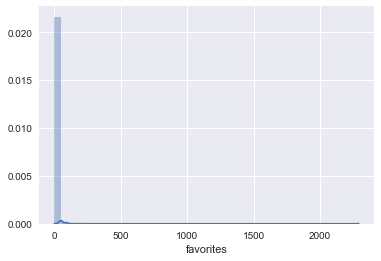

In [567]:
sns.distplot(all_tweets['favorites']);

In [568]:
all_tweets['favorites'].describe()


count    3122.000000
mean        3.649584
std        41.970591
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max      2288.000000
Name: favorites, dtype: float64

**The mean favorite count is : 2.7**

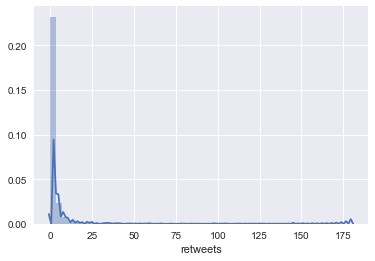

In [569]:
sns.distplot(all_tweets['retweets']);

In [570]:
all_tweets['retweets'].describe()

count    3122.000000
mean        3.385330
std        12.716582
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max       180.000000
Name: retweets, dtype: float64

**The mean retweets count is : 1.9**

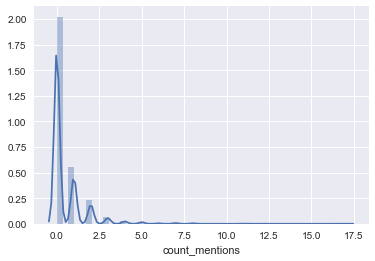

In [571]:
sns.distplot(all_tweets['count_mentions']);

In [572]:
all_tweets['count_mentions'].describe()

count    3122.000000
mean        0.549327
std         1.149356
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        17.000000
Name: count_mentions, dtype: float64

**The mean mentions count is : 0.78**

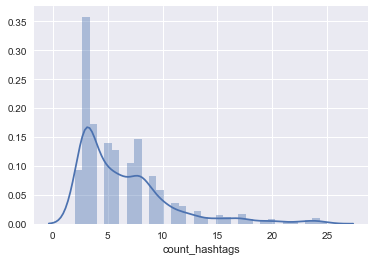

In [573]:
sns.distplot(all_tweets['count_hashtags']);

In [574]:
all_tweets['count_hashtags'].describe()

count    3122.000000
mean        6.519539
std         4.349860
min         2.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        25.000000
Name: count_hashtags, dtype: float64

**The mean hashtag count is : 4.17**

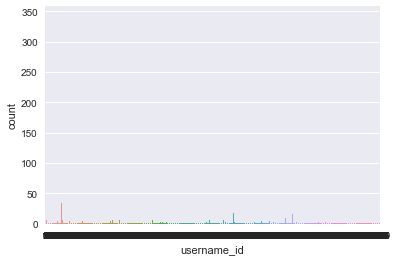

In [575]:
#sns.distplot(all_tweets['username_id']);
sns.countplot(x="username_id", data=all_tweets, orient='v');

In [576]:
all_tweets['username_id'].describe()

count    3122.000000
mean      747.129725
std       402.702502
min         0.000000
25%       418.250000
50%       828.000000
75%      1047.750000
max      1499.000000
Name: username_id, dtype: float64

**The unique members tweeted are : 609**

# 3 - See correlations among 2 variables

**Does the retweet count increases by number of mentions or hashtags ??**

* Obviously, for all tweets with >4 mentions or >10 hashtags, we dont see a high number for re-tweet count in below charts.


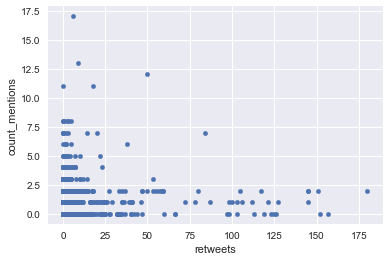

In [577]:
#scatter plot favorites/retweets
var = 'retweets'
data = pd.concat([all_tweets['count_mentions'], all_tweets[var]], axis=1)
data.plot.scatter(x=var, y='count_mentions');

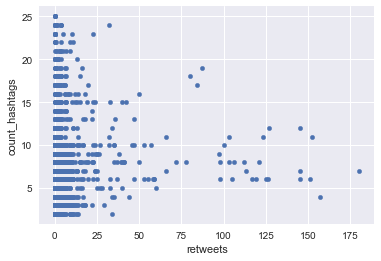

In [578]:
#scatter plot favorites/retweets
var = 'retweets'
data = pd.concat([all_tweets['count_hashtags'], all_tweets[var]], axis=1)
data.plot.scatter(x=var, y='count_hashtags');

**Does the favorites count increases by number of mentions or hashtags ??**

* Obviously, for all tweets with >4 mentions or >10 hashtags, we dont see a high number for favorites count in below charts.


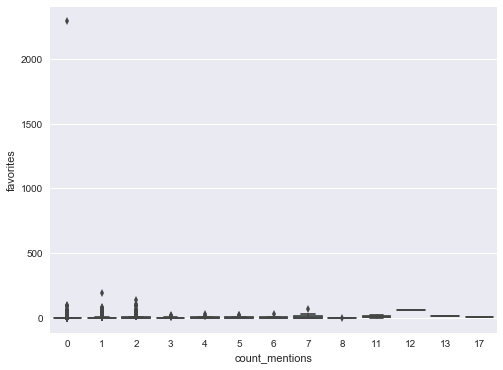

In [579]:
#box plot overallqual/saleprice
var = 'count_mentions'
data = pd.concat([all_tweets['favorites'], all_tweets[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="favorites", data=data)

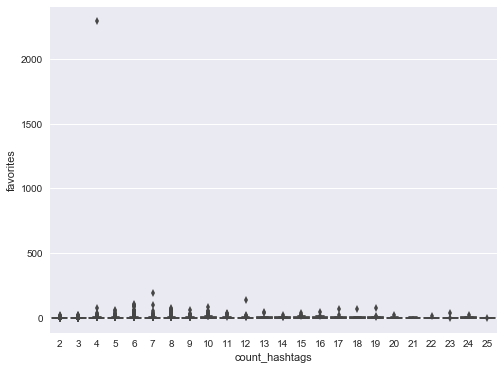

In [580]:
#box plot overallqual/saleprice
var = 'count_hashtags'
data = pd.concat([all_tweets['favorites'], all_tweets[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="favorites", data=data)

**Lets see the correlation among all columns**

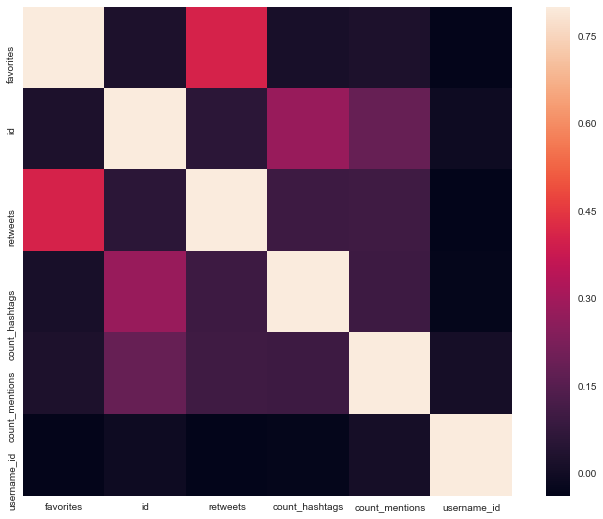

In [581]:
#correlation matrix
corrmat = all_tweets.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


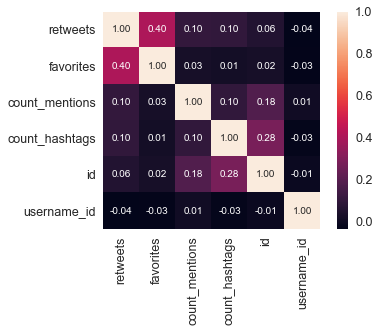

In [582]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'retweets')['retweets'].index
cm = np.corrcoef(all_tweets[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


**Observations:**
1. 75% correlation between retweet count and favorites count. It makes perfect sense as more people will like if the tweet reach more people.
2. This is very interesting to see 23% correlation between tweet_id, hashtag_count. If we see the below correlation between id and count_hashtags, we can see small tendency of using more hastags with increase in id value. This tells that people are using more hastags in recent time than before, makes perfect sense.

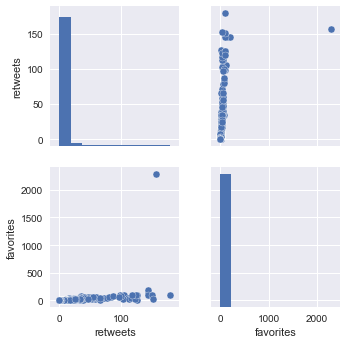

In [583]:
#scatterplot
sns.set()
cols = ['retweets',  'favorites']
sns.pairplot(all_tweets[cols], size = 2.5)
plt.show();

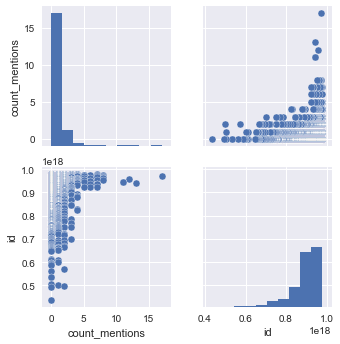

In [584]:
#scatterplot
sns.set()
cols = ['count_mentions', 'id']
sns.pairplot(all_tweets[cols], size = 2.5)
plt.show();


# 4 - Most Influential people

In [585]:
def grid_display(list_of_images, list_of_titles=[], list_of_profile_urls=[], no_of_columns=5, figsize=(10,10)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        response = requests.get(list_of_images[i])
        img = pImage.open(BytesIO(response.content))

        plt.imshow(img)
        plt.axis('off')
        #plt.axis.Axis.set_url(list_of_profile_urls[i])
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i], fontsize = 13)

In [586]:
def display_influential(df):
    print("profile_name - no_of_tweets - link_to_profile")
    list_of_images = []
    list_of_titles = []
    list_of_profile_urls = []
    for index, row in df.iterrows():
        p_url = 'https://twitter.com/'+ row['username'] +'/profile_image?size=original'
        list_of_images.append(p_url)
        list_of_titles.append(str(row['Size']) + ' - ' + row['username'])
        list_of_profile_urls.append("https://twitter.com/" + row['username'] )
        
    grid_display(list_of_images, list_of_titles, list_of_profile_urls)

profile_name - no_of_tweets - link_to_profile


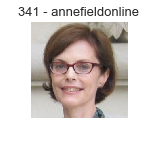

In [587]:
groups = all_tweets.copy(deep=True)
groups = groups[['username_id', 'username']]
groups = groups.groupby(['username_id', 'username']).size().reset_index(name='Size')
groups = groups.sort_values(by=['Size'], ascending=False)
groups = groups[groups['Size'] >= 50]

display_influential(groups)

# 5 - Analyse Co-occurring hashtags

Lets Analyse co-occurring hastags that we might want to include in our data collection.(If related to socialgood topic)

In [597]:
 pd.Series(' '.join(all_tweets['hashtags']).lower().split('#')).value_counts()[:50]


ai                         3147
agriculture                3137
iot                         894
robotics                    810
bigdata                     635
robots                      604
agritech                    455
drones                      428
farming                     370
machinelearning             346
agtech                      345
tech                        334
artificialintelligence      330
technology                  248
ml                          201
innovation                  188
dataanalytics               167
food                        131
iiot                        124
healthcare                  117
analytics                   116
automation                  115
datascience                 110
startup                      96
manufacturing                93
drone                        92
data                         83
digital                      83
energy                       78
foodtech                     77
future                       73
cloud   

In [589]:
all_tweets['sentiment'] = all_tweets[['clean_text']].applymap(lambda x: TextBlob(x).sentiment.polarity)


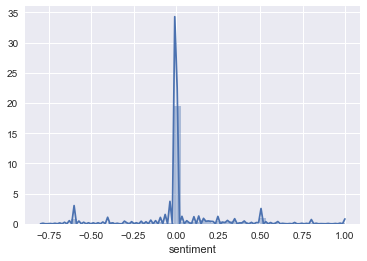

In [590]:
sns.distplot(all_tweets['sentiment']);

In [591]:
 all_tweets[all_tweets['sentiment'] >=0].sort_values(by=['sentiment'], ascending=False).head()[['clean_text']]

,clean_text
2557,"Are drones really, best, VRFA systems?"
2590,Seed retailers using products create best corn...
1985,Excellent topic! augment atus/897237584589598721
1639,InfoSecurity99: RT ChrisBarnouin: Using indust...
2883,Where greatest opportunities are: -


In [592]:
 all_tweets[all_tweets['sentiment'] <0].sort_values(by=['sentiment'], ascending=True).head()[['clean_text']]

,clean_text
3121,NSA panama city sheikh isa air base viral hemo...
3112,Dr. Erick Loetz teaching Intro Animal Science ...
2541,"How Sensors, Robotics And Artificial Intellige..."
2543,"How Sensors, Robotics And Artificial Intellige..."
2569,"How Sensors, Robotics And Artificial Intellige..."


In [593]:
all_tweets['year'] = all_tweets['date'].dt.year
all_tweets['month'] = all_tweets['date'].dt.month
all_tweets['day'] = all_tweets['date'].dt.day

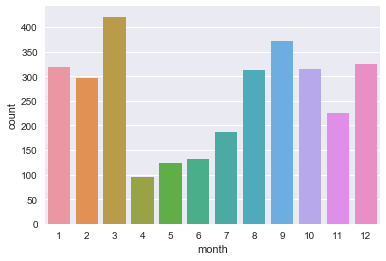

In [594]:
sns.countplot(x="month", data=all_tweets, orient='v');

In [595]:
all_tweets.head(2)

,date,favorites,hashtags,id,mentions,permalink,retweets,text,username,hashtags_list,mentions_list,count_hashtags,count_mentions,username_id,clean_text,sentiment,year,month,day
0,2018-03-30 11:33:01,3,#agriculture #Canada #AI #mining #oil #gas #Na...,979743304094019584,@Bioenterprise03,https://twitter.com/3DSNR/status/9797433040940...,2,RT @Bioenterprise03 The #agriculture industry ...,3DSNR,"[agriculture , canada , ai , mining , oil , ga...",[bioenterprise03],8,1,7,RT The industry resource sector shaken awake p...,0.03125,2018,3,30
1,2018-03-30 10:58:13,0,#farming #farm #agritech #agriculture #success...,979734549608333313,,https://twitter.com/99reviewz/status/979734549...,0,Are you a #farming fanatic that simply doesn't...,99reviewz,"[farming , farm , agritech , agriculture , suc...",[],15,0,12,Are fanatic simply time? Here something could ...,-0.15000,2018,3,30
